In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller


# 1. Load Dataset
file_path = "/Users/zulfanfaizun/Documents/ZULFAN/DEV/AIR QUALITY/dataset/AirQuality Dataset.csv"
df = pd.read_csv(file_path)

In [2]:
# 2. Preprocessing
# Mengganti string kosong dengan NaN
df.replace('', np.nan, inplace=True)

# Mengisi nilai NaN dengan forward fill (atau metode lain yang sesuai)
df.fillna(method="ffill", inplace=True)

# Mengubah kolom numerik menjadi float, menangani error jika ada
cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # errors='coerce' mengubah nilai yang tidak valid menjadi NaN

df_numeric = df[cols].astype(float) # Memastikan hanya kolom numerik yang digunakan.

# Check for missing values
print(df_numeric.isna().sum())

# Display the first 5 rows
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

Jan    87
Feb    66
Mar    33
Apr     9
May    58
Jun     6
Jul     4
Aug    11
Sep    11
Oct    31
Nov    91
Dec    51
dtype: int64
| Rank   | City      | Country   | 2023   | Jan   | Feb   | Mar   | Apr   | May   | Jun   | Jul   | Aug   | Sep   | Oct   | Nov   | Dec   |
|:-------|:----------|:----------|:-------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|:------|
| 1      | Begusarai | India     | 118.9  | 31.2  | 235.3 | 156.8 | 113   | 109.3 | 99    | 63.8  | 61.8  | 71.5  | 61.8  | 210.5 | 285   |
| 2      | Guwahati  | India     | 105.4  | 220.2 | 168.1 | 129.2 | 112.2 | 69.5  | 51.3  | 46.6  | 60.2  | 76.7  | 76.4  | 126.9 | 128   |
| 3      | Delhi     | India     | 102.1  | 171.8 | 114.3 | 77.4  | 71    | 67.4  | 42.9  | 35.3  | 34.8  | 39.7  | 106.3 | 255.1 | 210   |
| 4      | Mullanpur | India     | 100.4  | 106.3 | 123.7 | 78.1  | 56.6  | 53.4  | 53.9  | 63.2  | 59.7  | 59.6  | 110.4 | 253   | 201.4 |
| 5      | Lahore    | Paki

/var/folders/1_/klcd_b9n28ddb7ng8l2l7db80000gp/T/ipykernel_17226/4019028087.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


In [3]:
# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
data_scaled = imputer.fit_transform(df_numeric)

# Normalisasi Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_scaled)

# --- Uji Stasioneritas (ADF Test) ---
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Melakukan uji ADF untuk setiap kolom
for col in df_numeric.columns:
    print(f"Uji ADF untuk kolom {col}:")
    adf_test(data_scaled[:, df_numeric.columns.get_loc(col)]) # use correct index from data_scaled
    print("\n")

Uji ADF untuk kolom Jan:
ADF Statistic: -4.834934
p-value: 0.000047
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Uji ADF untuk kolom Feb:
ADF Statistic: -3.764808
p-value: 0.003289
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Uji ADF untuk kolom Mar:
ADF Statistic: -2.652196
p-value: 0.082682
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Uji ADF untuk kolom Apr:
ADF Statistic: -2.478459
p-value: 0.120804
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Uji ADF untuk kolom May:
ADF Statistic: -4.170207
p-value: 0.000740
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Uji ADF untuk kolom Jun:
ADF Statistic: -4.070805
p-value: 0.001082
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Uji ADF untuk kolom Jul:
ADF Statistic: -3.024037
p-value: 0.032710
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Uji ADF untuk kolom Aug:
ADF Statistic: -2.906322
p-value: 0.044618
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Uji ADF 

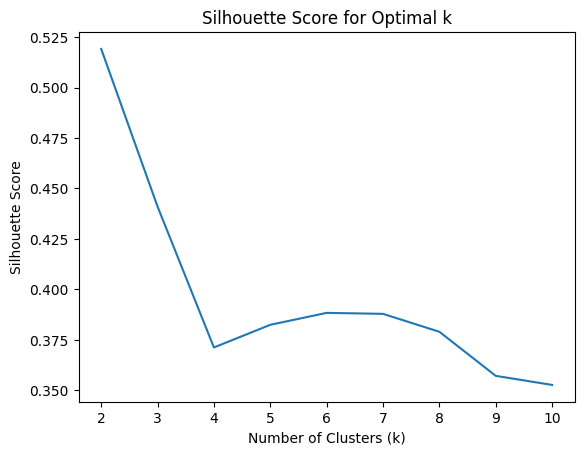

In [4]:
# 3. Deteksi Anomali dengan K-Means
# Mencari jumlah cluster (k) yang optimal dengan Silhouette Score
silhouette_scores = []
for n_clusters in range(2, 11):  # Mencoba jumlah cluster dari 2 hingga 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Visualisasi Silhouette Score untuk memilih k
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()

2025-02-09 17:52:01.326181: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-02-09 17:52:01.326216: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-09 17:52:01.326232: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-02-09 17:52:01.326425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-09 17:52:01.326439: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-02-09 17:52:02.803928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 0.1056 - val_loss: 0.0399
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.0463 - val_loss: 0.0135
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0393 - val_loss: 0.0107
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0388 - val_loss: 0.0110
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.0390 - val_loss: 0.0103
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0377 - val_loss: 0.0100
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0381 - val_loss: 0.0094
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0364 - val_loss: 0.0099
Epoch 9/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0358 - val_loss: 0.0093
Epoch 10/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0341 - val_loss: 0.0091


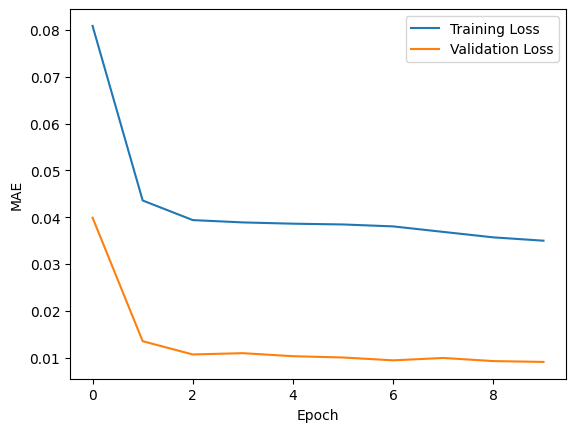

In [5]:
# Memilih k berdasarkan Silhouette Score tertinggi (misalnya k=3)
optimal_k = np.argmax(silhouette_scores) + 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(data_scaled)
df_numeric['KMeans_Distance'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)
threshold_kmeans = np.percentile(df_numeric['KMeans_Distance'], 95)
df_numeric['KMeans_Anomaly'] = df_numeric['KMeans_Distance'] > threshold_kmeans

# 4. Deteksi Anomali dengan Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_numeric['IsoForest_Anomaly'] = iso_forest.fit_predict(data_scaled)
df_numeric['IsoForest_Anomaly'] = df_numeric['IsoForest_Anomaly'] == -1

# 5. Deteksi Anomali dengan LSTM Autoencoder
TIME_STEPS = 3

# Fungsi untuk memisahkan data menjadi train dan validation
def split_data(data, train_ratio=0.8):
    return train_test_split(data, train_size=train_ratio, shuffle=False)

# Fungsi untuk membuat sequences data
def create_sequences(data, time_steps=TIME_STEPS):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
    return np.array(sequences)

X_train_full = create_sequences(data_scaled)
X_train, X_val = split_data(X_train_full)

# Fungsi build_autoencoder (dengan hyperparameter tuning sederhana)
def build_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(32, activation='relu', return_sequences=False)(encoded)
    decoded = RepeatVector(TIME_STEPS)(encoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_shape[1]))(decoded)
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mae') # Menggunakan MAE
    return autoencoder

input_shape = (TIME_STEPS, X_train.shape[2])
autoencoder = build_autoencoder(input_shape)

# Melatih model dengan validation data
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=16, validation_data=(X_val, X_val), verbose=1)

# Visualisasi Loss Training dan Validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


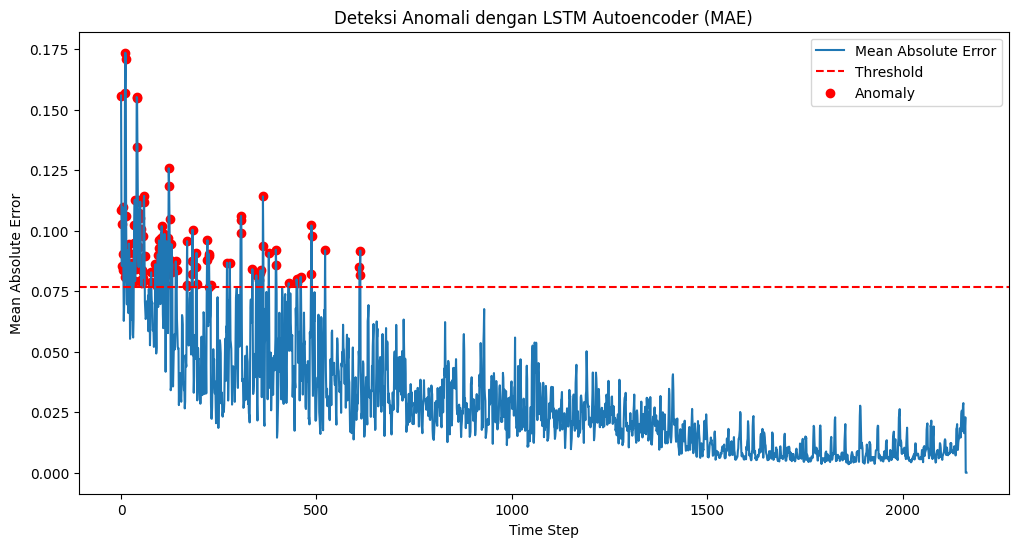

In [6]:
# Hitung Reconstruction Error (Menggunakan MAE)
X_pred = autoencoder.predict(X_train_full)
mae = np.mean(np.abs(X_pred - X_train_full), axis=(1, 2))

mae = np.append(mae, [False] * (TIME_STEPS - 2))
mae = np.append(mae, [False] * (TIME_STEPS - 2))
mae = np.append(mae, [False] * (TIME_STEPS - 2))

# Thresholding Adaptif
threshold_autoencoder = np.mean(mae) + 2 * np.std(mae)

# Assign MAE values to a new column in df_numeric
df_numeric['Autoencoder_MAE'] = mae

# Thresholding Adaptif
df_numeric['Autoencoder_Anomaly'] = df_numeric['Autoencoder_MAE'] > threshold_autoencoder

# 6. Visualisasi Hasil (dengan MAE dan Threshold Adaptif)
plt.figure(figsize=(12, 6))
plt.plot(mae, label="Mean Absolute Error")
plt.axhline(y=threshold_autoencoder, color='r', linestyle='--', label="Threshold")
plt.scatter(np.where(mae > threshold_autoencoder)[0], mae[mae > threshold_autoencoder], color='red', label="Anomaly")
plt.xlabel("Time Step")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.title("Deteksi Anomali dengan LSTM Autoencoder (MAE)")
plt.show()

In [7]:
# 7. Evaluasi dan Interpretasi
print("\nJumlah anomali berdasarkan metode:")
print("K-Means:", df_numeric['KMeans_Anomaly'].sum())
print("Isolation Forest:", df_numeric['IsoForest_Anomaly'].sum())
print("LSTM Autoencoder:", df_numeric['Autoencoder_Anomaly'].sum())


Jumlah anomali berdasarkan metode:
K-Means: 109
Isolation Forest: 109
LSTM Autoencoder: 123
